In [2]:
import optuna
from pathlib import Path
import plotly.express as px
import os

In [3]:
original_path = Path(".")
root_path = (Path(".").parent / "../data/baseline_studies/studies/sel/").resolve()
os.chdir(root_path)
p = Path("../images_baseline").resolve()
p.mkdir(exist_ok=True)

In [4]:
study_name = "study-knn_mozilla_200k_1000_samples-_24932448"
study_name = "study-svc_mozilla_200k_1000_samples-_24932435"
study_name = "study-bayesian-networks_mozilla_200k_1000_samples-_24932422"
study = optuna.load_study(study_name=study_name,storage=f"sqlite:///{study_name}.db")

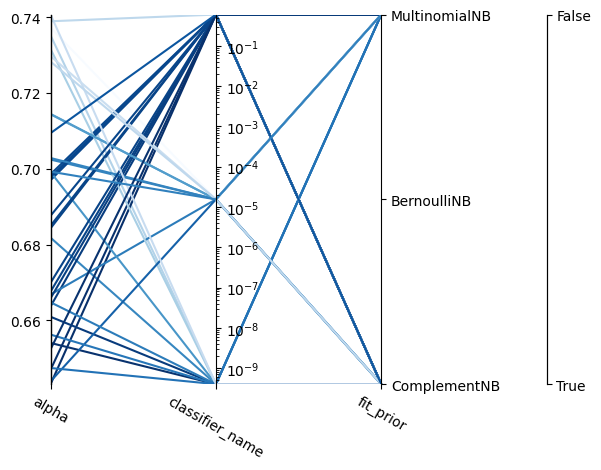

In [58]:
# Extracted from https://optuna.readthedocs.io/en/stable/_modules/optuna/visualization/matplotlib/_parallel_coordinate.html#plot_parallel_coordinate
import matplotlib.pyplot as plt
from optuna.visualization._parallel_coordinate import _get_parallel_coordinate_info
from optuna.visualization._parallel_coordinate import _ParallelCoordinateInfo
from optuna.visualization.matplotlib._matplotlib_imports import Axes
from optuna.visualization.matplotlib._matplotlib_imports import LineCollection
from typing import *
import numpy as np
def plot_parallel_coordinate(
    study,
    params,
    *,
    target = None,
    target_name: str = "Objective Value",
    cmap: str = "Blues_r",
    linewidths: float = 2,
    mapping: Optional[Dict[str,str]] = None
):
    info = _get_parallel_coordinate_info(study, params, target=target, target_name=target_name)
    return _get_parallel_coordinate_plot(info, cmap=cmap, linewidths=linewidths, mapping=mapping)
def _get_parallel_coordinate_plot(info, cmap, linewidths, mapping, colorbar: bool = False):
    target_name = info.target_name

    # Set up the graph style.
    fig, ax = plt.subplots()
    cmap = plt.get_cmap(cmap)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

    # Prepare data for plotting.
    if len(info.dims_params) == 0 or len(info.dim_objective.values) == 0:
        return ax

    obj_min = info.dim_objective.range[0]
    obj_max = info.dim_objective.range[1]
    obj_w = obj_max - obj_min
    dims_obj_base = [[] for _ in info.dim_objective.values]
    if mapping is None or (mapping is not None and "Objective Value" in mapping):
        for i,o in enumerate(info.dim_objective.values):
            dims_obj_base[i].append(o)
    for dim in info.dims_params:
        p_min = dim.range[0]
        p_max = dim.range[1]
        p_w = p_max - p_min

        if p_w == 0.0:
            center = obj_w / 2 + obj_min
            for i in range(len(dim.values)):
                dims_obj_base[i].append(center)
        else:
            for i, v in enumerate(dim.values):
                dims_obj_base[i].append((v - p_min) / p_w * obj_w + obj_min)

    # Draw multiple line plots and axes.
    # Ref: https://stackoverflow.com/a/50029441
    var_names = [dim.label for dim in info.dims_params]
    if mapping is None or (mapping is not None and "Objective Value" in mapping):
        var_names = [info.dim_objective.label] + var_names
    ax.set_xlim(0, len(info.dims_params))
    ax.set_ylim(min(d[0] for d in dims_obj_base), max(d[0] for d in dims_obj_base))
    xs = [range(len(var_names)) for _ in range(len(dims_obj_base))]
    segments = [np.column_stack([x, y]) for x, y in zip(xs, dims_obj_base)]
    lc = LineCollection(segments, cmap=cmap)
    lc.set_array(np.asarray(info.dim_objective.values))
    if colorbar:
        axcb = fig.colorbar(lc, pad=0.1, ax=ax)
        axcb.set_label(target_name)
    plt.xticks(range(len(var_names)), var_names, rotation=330)

    for i, dim in enumerate(info.dims_params):
        if mapping is not None and dim.label not in mapping:
            continue
        ax2 = ax.twinx()
        if dim.is_log:
            ax2.set_ylim(np.power(10, dim.range[0]), np.power(10, dim.range[1]))
            ax2.set_yscale("log")
        else:
            ax2.set_ylim(dim.range[0], dim.range[1])
        ax2.spines["top"].set_visible(False)
        ax2.spines["bottom"].set_visible(False)
        ax2.xaxis.set_visible(False)
        ax2.spines["right"].set_position(("axes", (i + 1) / len(info.dims_params)))
        if dim.is_cat:
            ax2.set_yticks(dim.tickvals)
            ax2.set_yticklabels(dim.ticktext)

    ax.add_collection(lc)

    return ax
mapping = {'algorithm':'Algorithm','leaf_size':'Leaf size','n_neighbors':'Number of neighbors','p':'p','weights':'Weight'}
mapping = {'C':'C (regularization)','class_weight':'Class weight','coef0':'coef0','decision_function_shape':'Decision fn shape','degree':'Degree', 'kernel': 'Kernel', 'max_iter': 'Max. iterations', 'shrinking':'Shrinking','tol':'Tolerance'}
mapping = {'alpha':'alpha','binarize':'Binarize','fit_prior':'Fit prior','classifier_name':'Classifier name'}
mapping = {'alpha':'alpha','classifier_name':'Classifier name','fit_prior':'Fit prior', 'norm':"Normalization"}
mapping = {'classifier_name':'Classifier name','var_smoothing':'Variable smoothing'}
mapping = {'alpha':'alpha','fit_prior':'Fit prior','classifier_name':'Classifier name'}#, 'Objective Value': 'AUC'}

params = [k for k in mapping if k != "Objective Value"]
fig = plot_parallel_coordinate(study,params,mapping=mapping)